In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
import seaborn as sns
import os

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV, SelectFromModel, SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
%matplotlib inline

In [19]:
Stock = pd.read_csv('AAPL.csv',  index_col=0)
df_Stock = Stock
df_Stock = df_Stock.rename(columns={'Close(t)':'Close'})
df_Stock.head()

,Open,High,Low,Close,Volume,SD20,Upper_Band,Lower_Band,S_Close(t-1),S_Close(t-2),...,QQQ_MA10,QQQ_MA20,QQQ_MA50,SnP_Close,SnP(t-1)),SnP(t-5),DJIA_Close,DJIA(t-1)),DJIA(t-5),Close_forcast
Date,,,,,,,,,,,,,,,,,,,,,
2005-10-17,6.66,6.69,6.50,6.60,154208600,0.169237,6.827473,6.150527,6.67,6.63,...,33.692,33.9970,34.2690,1190.10,1186.57,1187.33,10348.10,10287.34,10238.76,6.45
2005-10-18,6.57,6.66,6.44,6.45,152397000,0.168339,6.819677,6.146323,6.60,6.67,...,33.570,33.9525,34.2466,1178.14,1190.10,1184.87,10285.26,10348.10,10253.17,6.78
2005-10-19,6.43,6.78,6.32,6.78,252170800,0.180306,6.861112,6.139888,6.45,6.60,...,33.562,33.9600,34.2330,1195.76,1178.14,1177.68,10414.13,10285.26,10216.91,6.93
2005-10-20,6.72,6.97,6.71,6.93,339440500,0.202674,6.931847,6.121153,6.78,6.45,...,33.567,33.9455,34.2190,1177.80,1195.76,1176.84,10281.10,10414.13,10216.59,6.87
2005-10-21,7.02,7.03,6.83,6.87,199181500,0.216680,6.974860,6.108140,6.93,6.78,...,33.586,33.9365,34.2034,1179.59,1177.80,1186.57,10215.22,10281.10,10287.34,7.01


In [41]:
df_Stock = Stock.copy()

# Rename the 'Close(t)' column to 'Close'
df_Stock = df_Stock.rename(columns={'Close(t)': 'Close'})

# Calculate the average value of each column
column_averages = df_Stock.mean()

# Print the average values
print("Average values of each column:")
print(column_averages)

Average values of each column:
Open             8.719999e+01
High             8.809323e+01
Low              8.633580e+01
Close            8.725659e+01
Volume           1.143350e+08
                     ...     
SnP(t-5)         1.799223e+03
DJIA_Close       1.611508e+04
DJIA(t-1))       1.611037e+04
DJIA(t-5)        1.609162e+04
Close_forcast    8.737798e+01
Length: 62, dtype: float64


C:\Users\KOUSIK~1\AppData\Local\Temp/ipykernel_20460/942859822.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  column_averages = df_Stock.mean()


In [21]:
df_Stock.shape

(3732, 63)

In [22]:
df_Stock.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'SD20', 'Upper_Band',
       'Lower_Band', 'S_Close(t-1)', 'S_Close(t-2)', 'S_Close(t-3)',
       'S_Close(t-5)', 'S_Open(t-1)', 'MA5', 'MA10', 'MA20', 'MA50', 'MA200',
       'EMA10', 'EMA20', 'EMA50', 'EMA100', 'EMA200', 'MACD', 'MACD_EMA',
       'ATR', 'ADX', 'CCI', 'ROC', 'RSI', 'William%R', 'SO%K', 'STD5',
       'ForceIndex1', 'ForceIndex20', 'Date_col', 'Day', 'DayofWeek',
       'DayofYear', 'Week', 'Is_month_end', 'Is_month_start', 'Is_quarter_end',
       'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Is_leap_year',
       'Year', 'Month', 'QQQ_Close', 'QQQ(t-1)', 'QQQ(t-2)', 'QQQ(t-5)',
       'QQQ_MA10', 'QQQ_MA20', 'QQQ_MA50', 'SnP_Close', 'SnP(t-1))',
       'SnP(t-5)', 'DJIA_Close', 'DJIA(t-1))', 'DJIA(t-5)', 'Close_forcast'],
      dtype='object')

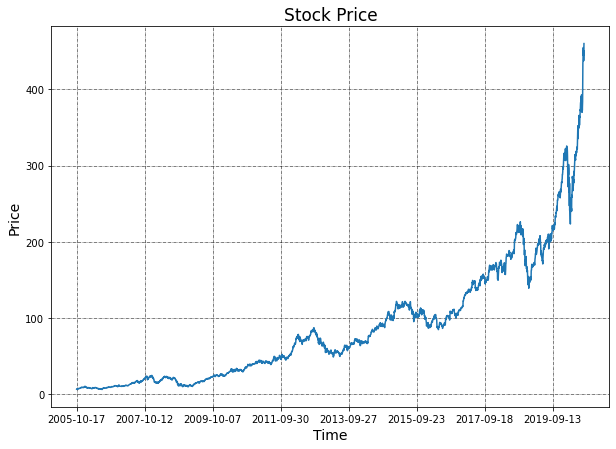

In [23]:
df_Stock['Close'].plot(figsize=(10, 7))
plt.title("Stock Price", fontsize=17)
plt.ylabel('Price', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

In [24]:
df_Stock = df_Stock.drop(columns='Date_col')

In [25]:
def create_train_test_set(df_Stock):
    
    features = df_Stock.drop(columns=['Close_forcast'], axis=1)
    target = df_Stock['Close_forcast']
    

    data_len = df_Stock.shape[0]
    print('Historical Stock Data length is - ', str(data_len))

    train_split = int(data_len * 0.88)
    print('Training Set length - ', str(train_split))

    val_split = train_split + int(data_len * 0.1)
    print('Validation Set length - ', str(int(data_len * 0.1)))

    print('Test Set length - ', str(int(data_len * 0.02)))

    X_train, X_val, X_test = features[:train_split], features[train_split:val_split], features[val_split:]
    Y_train, Y_val, Y_test = target[:train_split], target[train_split:val_split], target[val_split:]
    print(X_train.shape, X_val.shape, X_test.shape)
    print(Y_train.shape, Y_val.shape, Y_test.shape)
    
    return X_train, X_val, X_test, Y_train, Y_val, Y_test


In [26]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = create_train_test_set(df_Stock)

Historical Stock Data length is -  3732
Training Set length -  3284
Validation Set length -  373
Test Set length -  74
(3284, 61) (373, 61) (75, 61)
(3284,) (373,) (75,)


In [27]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, Y_train)

LinearRegression()

In [28]:
print('LR Coefficients: \n', lr.coef_)
print('LR Intercept: \n', lr.intercept_)

LR Coefficients: 
 [ 8.63721711e-03  1.86051843e-01  1.55487082e-01  1.12263751e+00
  1.27286912e-10  6.75229258e-03  1.40229160e-01  1.13219290e-01
  4.25627818e-02  8.96348284e-02  1.01914943e-01  5.94183504e-02
  7.95194240e-02  7.10399629e-02  2.71424954e-01  1.26724338e-01
  8.79333381e-02 -5.87980398e-03 -3.31643358e-01 -3.31643358e-01
 -3.31643358e-01 -3.31643358e-01 -3.31643358e-01  1.88650012e+00
 -1.27270716e+00 -1.65042231e-01 -4.36658424e-04  6.89069378e-13
 -5.07434138e-03  9.02936470e-03  5.78317131e-04  5.78317131e-04
 -5.57917913e-01 -2.02304395e-10  4.18931834e-11  1.69322438e-02
  1.61636703e-02 -1.75659583e-02  6.12165518e-03  2.15420351e-01
  1.13979656e-01 -2.41954675e-01  7.63050274e-02  3.73276598e-01
  5.55111512e-16 -5.60843990e-02  4.08788803e-02  5.13473865e-01
 -2.94431531e-02 -8.41335093e-02  5.10939129e-02 -8.14435749e-03
 -1.95035199e-02  5.67587242e-02  4.39707789e-02  1.29311735e-02
 -9.99967520e-03 -3.89778363e-03 -1.62174809e-03  1.44436894e-03
  2.83

In [29]:
print("Performance (R^2): ", lr.score(X_train, Y_train))

Performance (R^2):  0.9994516474373267


In [30]:
def get_mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [31]:
Y_train_pred = lr.predict(X_train)
Y_val_pred = lr.predict(X_val)
Y_test_pred = lr.predict(X_test)

In [32]:
print("Training R-squared: ",round(metrics.r2_score(Y_train,Y_train_pred),2))
print("Training Explained Variation: ",round(metrics.explained_variance_score(Y_train,Y_train_pred),2))
print('Training MAPE:', round(get_mape(Y_train,Y_train_pred), 2)) 
print('Training Mean Squared Error:', round(metrics.mean_squared_error(Y_train,Y_train_pred), 2)) 
print("Training RMSE: ",round(np.sqrt(metrics.mean_squared_error(Y_train,Y_train_pred)),2))
print("Training MAE: ",round(metrics.mean_absolute_error(Y_train,Y_train_pred),2))

print(' ')

print("Validation R-squared: ",round(metrics.r2_score(Y_val,Y_val_pred),2))
print("Validation Explained Variation: ",round(metrics.explained_variance_score(Y_val,Y_val_pred),2))
print('Validation MAPE:', round(get_mape(Y_val,Y_val_pred), 2)) 
print('Validation Mean Squared Error:', round(metrics.mean_squared_error(Y_train,Y_train_pred), 2)) 
print("Validation RMSE: ",round(np.sqrt(metrics.mean_squared_error(Y_val,Y_val_pred)),2))
print("Validation MAE: ",round(metrics.mean_absolute_error(Y_val,Y_val_pred),2))

print(' ')

print("Test R-squared: ",round(metrics.r2_score(Y_test,Y_test_pred),2))
print("Test Explained Variation: ",round(metrics.explained_variance_score(Y_test,Y_test_pred),2))
print('Test MAPE:', round(get_mape(Y_test,Y_test_pred), 2)) 
print('Test Mean Squared Error:', round(metrics.mean_squared_error(Y_test,Y_test_pred), 2)) 
print("Test RMSE: ",round(np.sqrt(metrics.mean_squared_error(Y_test,Y_test_pred)),2))
print("Test MAE: ",round(metrics.mean_absolute_error(Y_test,Y_test_pred),2))


Training R-squared:  1.0
Training Explained Variation:  1.0
Training MAPE: 1.45
Training Mean Squared Error: 1.48
Training RMSE:  1.22
Training MAE:  0.76
 
Validation R-squared:  0.99
Validation Explained Variation:  0.99
Validation MAPE: 1.68
Validation Mean Squared Error: 1.48
Validation RMSE:  5.91
Validation MAE:  3.75
 
Test R-squared:  0.96
Test Explained Variation:  0.97
Test MAPE: 1.77
Test Mean Squared Error: 79.21
Test RMSE:  8.9
Test MAE:  6.5


In [33]:
df_pred = pd.DataFrame(Y_val.values, columns=['Actual'], index=Y_val.index)
df_pred['Predicted'] = Y_val_pred
df_pred = df_pred.reset_index()
df_pred.loc[:, 'Date'] = pd.to_datetime(df_pred['Date'],format='%Y-%m-%d')
df_pred

,Date,Actual,Predicted
0,2018-11-01,202.30,216.289778
1,2018-11-02,196.56,201.470182
2,2018-11-05,198.68,195.948933
3,2018-11-06,204.71,199.043601
4,2018-11-07,204.00,204.193666
...,...,...,...
368,2020-04-22,273.79,275.751755
369,2020-04-23,281.70,274.020243
370,2020-04-24,281.90,280.710044
371,2020-04-27,277.33,280.543603


<AxesSubplot:>

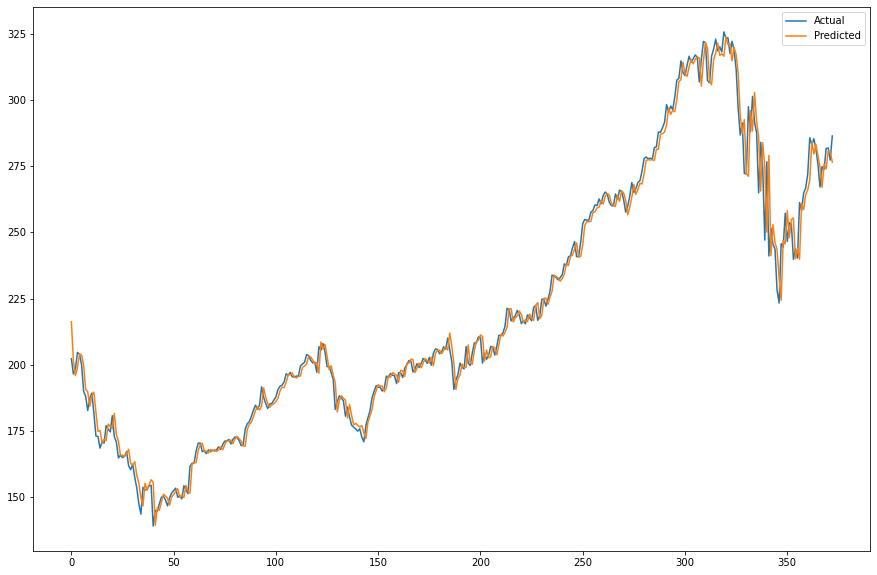

In [34]:
df_pred[['Actual', 'Predicted']].plot(figsize=(15, 10))

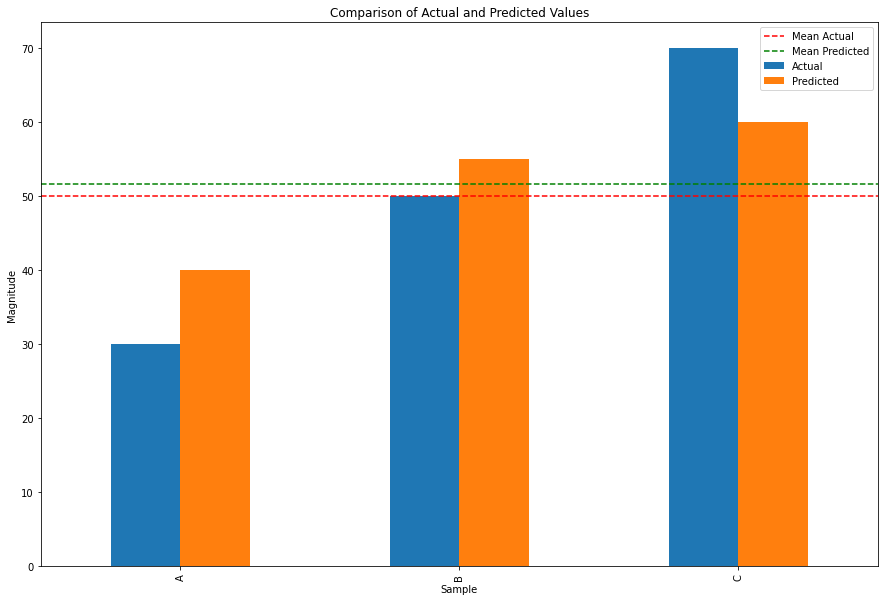

In [35]:
df_pred = pd.DataFrame({'Sample': ['A', 'B', 'C'], 'Actual': [30, 50, 70], 'Predicted': [40, 55, 60]})

mean_actual = np.mean(df_pred['Actual'])
mean_predicted = np.mean(df_pred['Predicted'])

ax = df_pred.plot(kind='bar', x='Sample', y=['Actual', 'Predicted'], figsize=(15, 10))

ax.axhline(y=mean_actual, color='r', linestyle='--', label='Mean Actual')
ax.axhline(y=mean_predicted, color='g', linestyle='--', label='Mean Predicted')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Magnitude')
plt.title('Comparison of Actual and Predicted Values')
plt.show()

In [36]:
#This is a Python code for stock price prediction using linear regression. The code reads stock data from a CSV file, creates a train-test split, fits a linear regression model, and evaluates its performance on training, validation, and test sets. The evaluation metrics used are R-squared, explained variation, mean absolute percentage error (MAPE), mean squared error (MSE), root mean squared error (RMSE), and mean absolute error (MAE). The code also plots the actual and predicted values for the validation set.

#The code starts with importing the required libraries such as pandas, matplotlib, numpy, seaborn, os, and scikit-learn. Then, it reads the stock data from a CSV file into a pandas dataframe and performs some data preprocessing such as renaming a column and dropping another column. Next, it defines a function named create_train_test_set that creates a train-test split of the data using a chronological split. The function takes a dataframe as input and returns six dataframes, namely X_train, X_val, X_test, Y_train, Y_val, and Y_test.

#The code then fits a linear regression model on the training set using scikit-learn's LinearRegression class and prints the coefficients, intercept, and performance (R-squared) of the model. It also defines a function named get_mape that computes the mean absolute percentage error (MAPE) between the actual and predicted values.

#Next, the code predicts the target values (Close_forcast) for the training, validation, and test sets using the trained model and evaluates its performance on each set using various metrics. Finally, the code plots the actual and predicted values for the validation set using pandas and matplotlib.